# [RTS-GMLC](https://github.com/gridmod/rts-gmlc) & [PowerSimulations.jl](https://github.com/NREL/PowerSimulations.jl)

This notebook demonstrates how to run production cost modeling and other simulations on the RTS-GMLC data using PowerSimulations.jl

*This notebook was developed on 9/12/2019 using [a development branch of PowerSimulations.jl](https://github.com/NREL/PowerSimulations.jl/commit/c8e8bb5b02b149351c4b5036e8349b971aa2e3c0) - stability is unlikely*


## Environment
This notebook depends a Julia environment defined in https://github.com/NREL-SIIP/Examples/env , it can be instantiated by running the following command in a cell or terminal:
```
] activate env; instantiate;
```

In [1]:
] activate env

Activating environment at `~/Documents/repos/Examples/env/Project.toml`


In [2]:
] st

    Status `~/Documents/repos/Examples/env/Project.toml`
  [9961bab8] Cbc v0.6.4
  [5ae59095] Colors v0.9.6
  [41994980] D3TypeTrees v0.1.1
  [a93c6f00] DataFrames v0.19.4
  [e2685f51] ECOS v0.10.0
  [60bf3e95] GLPK v0.11.4
  [b6b21f68] Ipopt v0.6.0
  [4076af6c] JuMP v0.20.0
  [51fcb6bd] NamedColors v0.2.0
  [f0f68f2c] PlotlyJS v0.12.5
  [91a5bcdd] Plots v0.26.3
  [e690365d] PowerSimulations v0.2.0 #master (https://github.com/NREL/PowerSimulations.jl.git)
  [bcd98974] PowerSystems v0.4.1
  [9e3dc215] TimeSeries v0.16.0
  [0f1e0344] WebIO v0.8.11


In [3]:
using Revise
using PowerSystems
using PowerSimulations
const PSY = PowerSystems
const PSI = PowerSimulations
const IS = PSY.InfrastructureSystems

┌ Info: Recompiling stale cache file /Users/cbarrows/.julia/compiled/v1.2/Revise/M1Qoh.ji for Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/cbarrows/.julia/compiled/v1.2/PowerSimulations/ixScC.ji for PowerSimulations [e690365d-45e2-57bb-ac84-44ba829e73c4]
└ @ Base loading.jl:1240


InfrastructureSystems

In [4]:
using JuMP
using Dates

In [5]:
# not working
using Xpress
Xpress_optimizer = JuMP.with_optimizer(Xpress.Optimizer,OUTPUTLOG = 1,MIPTOL=1e-6,FEASTOL=1e-6)


ArgumentError: ArgumentError: Package Xpress not found in current path:
- Run `import Pkg; Pkg.add("Xpress")` to install the Xpress package.


In [5]:
using GLPK
GLPK_optimizer = JuMP.with_optimizer(GLPK.Optimizer)

┌ Info: Recompiling stale cache file /Users/cbarrows/.julia/compiled/v1.2/GLPK/r6CoY.ji for GLPK [60bf3e95-4087-53dc-ae20-288a0d20c6a6]
└ @ Base loading.jl:1240


OptimizerFactory(GLPK.Optimizer, (), Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}())

In [6]:
using Cbc
Cbc_optimizer = JuMP.with_optimizer(Cbc.Optimizer, logLevel=1, ratioGap=0.1)

┌ Info: Recompiling stale cache file /Users/cbarrows/.julia/compiled/v1.2/Cbc/ARPfV.ji for Cbc [9961bab8-2fa3-5c5a-9d89-47fab24efd76]
└ @ Base loading.jl:1240


OptimizerFactory(Cbc.Optimizer, (), Base.Iterators.Pairs{Symbol,Real,Tuple{Symbol,Symbol},NamedTuple{(:logLevel, :ratioGap),Tuple{Int64,Float64}}}(:logLevel => 1,:ratioGap => 0.1))

## Get the RTS data
Available at https://github.com/GridMod/RTS-GMLC/ or by running the following in a terminal:
```
git clone https://github.com/GridMod/RTS-GMLC/
```

In [38]:
# path to "reformat-DC" branch of RTS-GMLC repo: https://github.com/GridMod/RTS-GMLC/
RTSDIR = "../RTS-GMLC/RTS_Data/SourceData/."

"../RTS-GMLC/RTS_Data/SourceData/."

## Parse the tabular data

In [42]:
rts_data = PSY.PowerSystemTableData(RTSDIR, 
    100.0,joinpath(RTSDIR,"../FormattedData/SIIP/user_descriptors.yaml"))

┌ Info: Parsing csv data in branch.csv ...
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:151
┌ Info: Successfully parsed branch.csv
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:156
┌ Info: Parsing csv data in bus.csv ...
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:151
┌ Info: Successfully parsed bus.csv
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:156
┌ Info: Parsing csv data in dc_branch.csv ...
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:151
┌ Info: Successfully parsed dc_branch.csv
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:156
┌ Info: Parsing csv data in gen.csv ...
└ @ PowerSystems /Users/cbarrows/.julia/packages

PowerSystems.PowerSystemTableData:
  directory:  ../RTS-GMLC/RTS_Data/SourceData/.
  timeseries_metadata_file:  ../RTS-GMLC/RTS_Data/SourceData/./timeseries_pointers.csv
  basepower:  100.0
  branch:  120×14 DataFrames.DataFrame
  bus:  73×15 DataFrames.DataFrame
  dcline:  1×60 DataFrames.DataFrame
  gen:  158×57 DataFrames.DataFrame
  load:  no data
  services:  7×5 DataFrames.DataFrame


## Create a `System`
The tabular data includes forecasts with different resolutions (hourly and 5-minute), but a `System` is specific to a resolution.

In [43]:
sys_DA = System(rts_data; forecast_resolution = Dates.Hour(1))

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Generator Category is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Devices is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Requirement is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Eligible Generator Categories is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Reserve Category is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Variable Cost is not in dataframe.
└ @

┌ Warning: User-defined column name Interruption Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Power Factor is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Generator Category is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Variable Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Fixed Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Start-up Cost is not in dataframe.
└ @ PowerSyste

,ConcreteType,SuperTypes,Count
,String,String,Int64
1,Bus,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,73
2,GenericBattery,Storage <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
3,HVDCLine,DCBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
4,HydroDispatch,HydroGen <: Generator <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,20
5,Line,ACBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,104
6,LoadZones,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,3
7,PowerLoad,StaticLoad <: ElectricLoad <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,73
8,ProportionalReserve,Reserve <: Service <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,7
9,RenewableDispatch,RenewableGen <: Generator <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,30


## Create a 5-minute `System`

In [44]:
sys_RT = System(rts_data; forecast_resolution = Dates.Minute(5))

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Min is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Voltage Limit Max is not in datafr

┌ Warning: User-defined column name Variable Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Fixed Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Start-up Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Shutdown Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Capacity Factor is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Curtailment Cost is not in dataframe.
└ @ PowerSystems 

┌ Warning: User-defined column name Interruption Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Power Factor is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Generator Category is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Variable Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Fixed Cost is not in dataframe.
└ @ PowerSystems /Users/cbarrows/.julia/packages/PowerSystems/iRrXM/src/parsers/power_system_table_data.jl:862
┌ Warning: User-defined column name Start-up Cost is not in dataframe.
└ @ PowerSyste

,ConcreteType,SuperTypes,Count
,String,String,Int64
1,Bus,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,73
2,GenericBattery,Storage <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
3,HVDCLine,DCBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
4,HydroDispatch,HydroGen <: Generator <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,20
5,Line,ACBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,104
6,LoadZones,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,3
7,PowerLoad,StaticLoad <: ElectricLoad <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,73
8,ProportionalReserve,Reserve <: Service <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,7
9,RenewableDispatch,RenewableGen <: Generator <: Injection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,30


## Manipulating forecasts for simulaitons

 - A problem depends upon a set of consistent forecasts
  - Initial time
  - Length
  - Resolution (enforced by `System` instantiation

In [47]:
 get_forecast_initial_times(sys_DA)

1-element Array{DateTime,1}:
 2020-01-01T00:00:00

In [48]:
# This will be added to InfrastructureSystems
function subset_forecasts!(sys, forecast_type, initial_time, from_time, to_time)
    fcs = get_forecasts(forecast_type, sys, initial_time)
    new_fcs = []
    for fc in fcs
        res = IS.get_resolution(fc)
        new_fc = Deterministic(get_component(fc),
            IS.get_label(fc), 
            res, 
            from_time,
            PSY.get_data(fc)[from_time:res:to_time])
        push!(new_fcs, new_fc)
    end
    [remove_forecast!(sys, fc) for fc in fcs]
    [PSY.add_forecast!(sys, new_fc) for new_fc in new_fcs]

end

subset_forecasts! (generic function with 1 method)

## Subset `Forecasts`

In [51]:
subset_forecasts!(sys_DA, Deterministic, 
    get_forecast_initial_times(sys_DA)[1], 
    DateTime("2020-04-04T00:00:00"), 
    DateTime("2020-04-12T23:00:00"));

┌ Info: Deleted forecast 67f83679-9fde-4716-9465-1e585ac11090
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 06987adf-6ccc-48f3-9973-5060a2702e90
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast f84c9457-36ff-4076-86c3-ea4b48ddc9b2
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast e5b7579c-01eb-48c9-bebd-847784f0581e
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast a42f3ad5-28c0-4e44-b738-715289a30f5f
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 45b20266-f724-4bed-a095-05d214255740
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/for

┌ Info: Deleted forecast 3d427e2f-fbb7-4a0c-a2d9-9a032433f056
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast b3283cee-0bc8-427c-a6ca-6149896befb1
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast e205a127-90d2-4b6b-a65e-1cedd0b88437
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 170458a9-19e8-4d83-af75-cf2da01b60bf
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 8112928f-2f61-4242-af04-e575401e0005
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 9680c79b-fa94-4e69-b9f8-4df7c15bdd0e
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/for

┌ Info: Deleted forecast e9dec691-e3e5-462c-81fe-53053432fea4
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast b85bc9c4-e33c-4929-a288-7220c4efc134
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 31ecc29c-636e-46e0-9b22-68cb35ac5626
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast af0908ac-d13c-4bd4-9b89-5bdc5b593c6f
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 9fda21a9-45bc-461f-99d8-193a395549de
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 37efd3d4-e95b-40a6-b517-3d2380961c13
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/for

┌ Info: Deleted forecast 97d695f4-ac24-4cba-8333-963927830750
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 0fc26c52-3dcc-459d-8439-057af17a0d2b
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 99db270f-dd68-4695-83c9-5f716049ddfd
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast a8472e8e-d14f-4418-9a90-8267292ccbb0
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast ee7d1042-6871-4700-b86a-80e335a2bea9
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 0b981b6d-5a39-4a61-b8cc-bb508dcd6c42
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/for

In [52]:
PSY.get_forecast_initial_times(sys_DA)

1-element Array{DateTime,1}:
 2020-04-04T00:00:00

In [54]:
subset_forecasts!(sys_RT, Deterministic, 
    get_forecast_initial_times(sys_RT)[1], 
    DateTime("2020-04-04T00:00:00"), 
    DateTime("2020-04-12T23:00:00"));

┌ Info: Deleted forecast 6111685c-ab93-4a04-bc55-4368660320c3
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 66fb9d9f-1072-4c63-aec1-0e8e722df64f
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast c9bd656b-a26e-4604-b35f-c0a85d041920
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 740bd0f7-be57-4616-bdf1-04a661802c75
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast ca852c53-ee85-4251-8209-02f347e265a8
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 49b8d46c-db61-40aa-a6fa-36944491a634
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/for

┌ Info: Deleted forecast 5a016949-9a9b-47ed-9bae-2f7f6ce14b21
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 55a16a6a-fff0-4ba7-b597-c08e204f945a
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 66187175-ceea-4314-8845-2311532ac65f
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 3e4fedce-b37c-4531-b707-e25f9649a8a8
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 836c1b56-c283-47c8-bda6-6006710ec22b
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 72a20b61-4b24-49b8-b505-a26ac88b532e
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/for

┌ Info: Deleted forecast 7a365271-5965-486a-98f6-a5211620c6dd
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 4f20657c-9647-4213-b888-f969ecfb2d12
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 873740e4-b658-4ca6-bc6e-d163de4c5197
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast cfc0b0cf-0a80-446b-9189-c28af5c2b4db
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 3a873f57-f900-4aae-a8da-a559ccd6e474
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 49015020-a78f-4c48-ae59-0f58e6c738fb
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/for

┌ Info: Deleted forecast 239bef5f-2732-493b-85ca-1b2649abfb8a
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 62595ccc-108d-4a14-860b-cb923f79551a
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast 5e0f9cc5-8ce1-4d2b-b1c0-a6d54c385432
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast ec221f65-4d3e-4fd6-81d9-9f553c6c69c3
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast c9230727-6dc8-4526-9270-055d40a68da7
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:407
┌ Info: Deleted forecast a19f6c69-18e7-4f69-9cc3-f398604a7efb
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/for

## Split `Forecasts`

In [53]:
split_forecasts!(sys_DA, 
    get_forecasts(Deterministic, sys_DA, PSY.get_forecast_initial_times(sys_DA)[1]),
    Dates.Hour(24),
    48)

┌ Info: Reset system forecast information.
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:107


In [66]:
PSY.get_forecast_initial_times(sys_DA)

8-element Array{DateTime,1}:
 2020-04-04T00:00:00
 2020-04-05T00:00:00
 2020-04-06T00:00:00
 2020-04-07T00:00:00
 2020-04-08T00:00:00
 2020-04-09T00:00:00
 2020-04-10T00:00:00
 2020-04-11T00:00:00

In [55]:
split_forecasts!(sys_RT, 
    get_forecasts(Deterministic, sys_RT, get_forecast_initial_times(sys_RT)[1]),
    Dates.Minute(5),
    12)

┌ Info: Reset system forecast information.
└ @ InfrastructureSystems /Users/cbarrows/.julia/packages/InfrastructureSystems/vJOMW/src/forecasts.jl:107


In [67]:
PSY.get_forecast_initial_times(sys_RT)

2570-element Array{DateTime,1}:
 2020-04-04T00:00:00
 2020-04-04T00:05:00
 2020-04-04T00:10:00
 2020-04-04T00:15:00
 2020-04-04T00:20:00
 2020-04-04T00:25:00
 2020-04-04T00:30:00
 2020-04-04T00:35:00
 2020-04-04T00:40:00
 2020-04-04T00:45:00
 2020-04-04T00:50:00
 2020-04-04T00:55:00
 2020-04-04T01:00:00
 ⋮                  
 2020-04-12T21:10:00
 2020-04-12T21:15:00
 2020-04-12T21:20:00
 2020-04-12T21:25:00
 2020-04-12T21:30:00
 2020-04-12T21:35:00
 2020-04-12T21:40:00
 2020-04-12T21:45:00
 2020-04-12T21:50:00
 2020-04-12T21:55:00
 2020-04-12T22:00:00
 2020-04-12T22:05:00

## Serialize (save) data

In [ ]:
# TODO: load from here.
to_json(sys_DA,"sys_DA_44_412.json")
to_json(sys_RT,"sys_RT_44_412.json")

# Setup Single-Step Problem

## Create a recipe of devices and formulations

In [56]:
## UC Model Ref
branches = Dict{Symbol, DeviceModel}(#:L => DeviceModel(PSY.Line, PSI.StaticLine),
                                     #:T => DeviceModel(PSY.Transformer2W, PSI.StaticTransformer),
                                     #:TT => DeviceModel(PSY.TapTransformer, PSI.StaticTransformer),
                                     #:dc_line => DeviceModel(PSY.HVDCLine, PSI.HVDCDispatch)
                                    )

services = Dict{Symbol, PSI.ServiceModel}()

devices = Dict{Symbol, DeviceModel}(:Generators => DeviceModel(PSY.ThermalStandard, PSI.ThermalBasicUnitCommitment),
                                    :Ren => DeviceModel(PSY.RenewableDispatch, PSI.RenewableFullDispatch),
                                    :Loads =>  DeviceModel(PSY.PowerLoad, PSI.StaticPowerLoad),
                                    #:ILoads =>  DeviceModel(PSY.InterruptibleLoad, PSI.StaticPowerLoad),
                                    )       


model_ref_uc= ModelReference(CopperPlatePowerModel, devices, branches, services);

In [57]:
struct foo <: PSI.AbstractOperationModel end # just a placeholder for single step problems


## Apply model recipe to data to build an `OperationModel`

In [58]:
op_model = OperationModel(foo, model_ref_uc, sys_DA, optimizer = Cbc_optimizer)

┌ Info: Building ThermalStandard with ThermalBasicUnitCommitment formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/core/build_operations.jl:14
┌ Info: Setting DeviceStatus initial conditions for the status of all devices ThermalStandard based on system data
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/make_initial_conditions.jl:19
┌ Info: Setting DevicePower initial_condition of all devices ThermalStandard based on system data
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/make_initial_conditions.jl:57
┌ Info: Setting TimeDurationON initial_condition of all devices ThermalStandard based on system data
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/make_initial_conditions.jl:97
┌ Info: Setting TimeDurationOFF initial_condition of all devices ThermalStandard based on system data
└ @ PowerSimulations /Users/cbarrows/.juli


Operation Model

  transmission:  CopperPlatePowerModel

  devices: 
      Generators:
        device = ThermalStandard
        formulation = ThermalBasicUnitCommitment
      Ren:
        device = RenewableDispatch
        formulation = RenewableFullDispatch
      Loads:
        device = PowerLoad
        formulation = StaticPowerLoad


  branches: 


  services:  Dict{Symbol,PowerSimulations.ServiceModel}()



## Solve the single-step problem contained in `OperationModel`

In [59]:
res = solve_op_model!(op_model)

┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{Cbc.Optimizer,MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.Model{Float64}}}}. This 
│   information will be discarded. = information will be discarded.
└ @ MathOptInterface.Utilities /Users/cbarrows/.julia/packages/MathOptInterface/4hMCx/src/Utilities/copy.jl:140
┌ Warning: SolveTime() property not supported by COIN Branch-and-Cut (Cbc)
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/get_results.jl:76


Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Dec 31 2018 

command line - Cbc_C_Interface -ratioGap 0.1 -logLevel 1 -solve -quit (default strategy 1)
ratioGap was changed from 0 to 0.1
Continuous objective value is 1.9061e+06 - 0.36 seconds
Cgl0004I processed model has 17671 rows, 28162 columns (10786 integer (10786 of which binary)) and 56355 elements
Cbc0038I Initial state - 567 integers unsatisfied sum - 147.794
Cbc0038I Pass   1: (0.72 seconds) suminf.    4.46719 (31) obj. 2.02434e+06 iterations 3363
Cbc0038I Pass   2: (0.74 seconds) suminf.    0.57622 (16) obj. 2.02785e+06 iterations 85
Cbc0038I Pass   3: (0.76 seconds) suminf.    0.00000 (0) obj. 2.16348e+06 iterations 114
Cbc0038I Solution found of 2.16348e+06
Cbc0038I Relaxing continuous gives 2.13854e+06
Cbc0038I Before mini branch and bound, 10188 integers at bound fixed and 15480 continuous
Cbc0038I Full problem 17671 rows 28162 columns, reduced to 132 rows 435 columns
Cbc0038I Mini branch and bound improved s

Results Model


In [23]:
res.variables[:ON_ThermalStandard]

,322_CT_6,321_CC_1,202_STEAM_3,315_STEAM_1,223_CT_4,123_STEAM_2,213_CT_1,223_CT_6
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Plotting results is a work in progress...

In [60]:
using Plots
gr()

Plots.GRBackend()

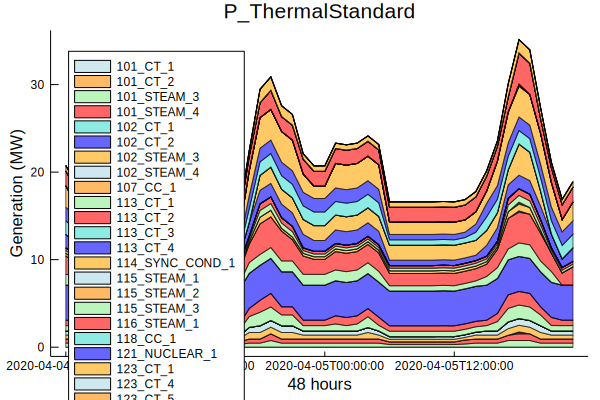

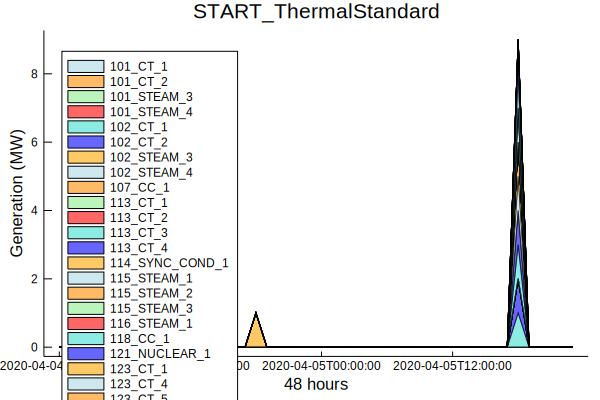

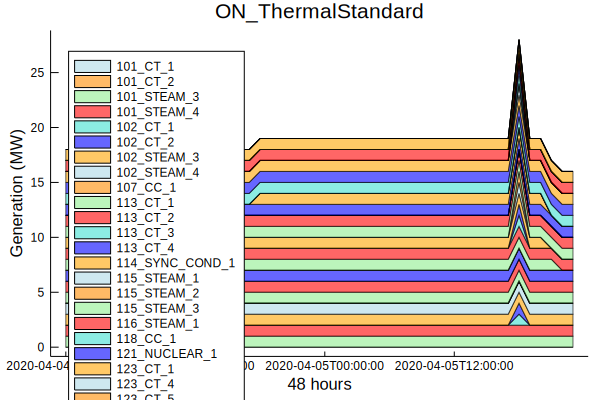

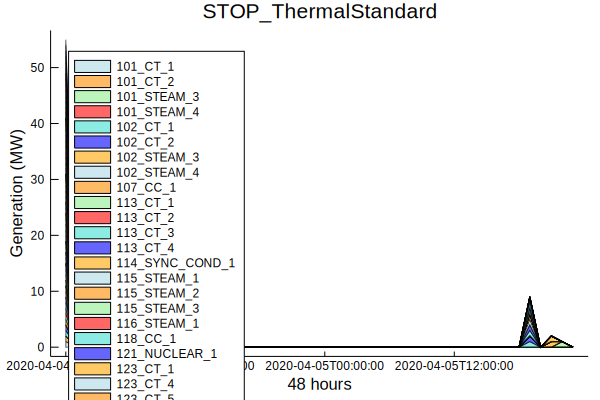

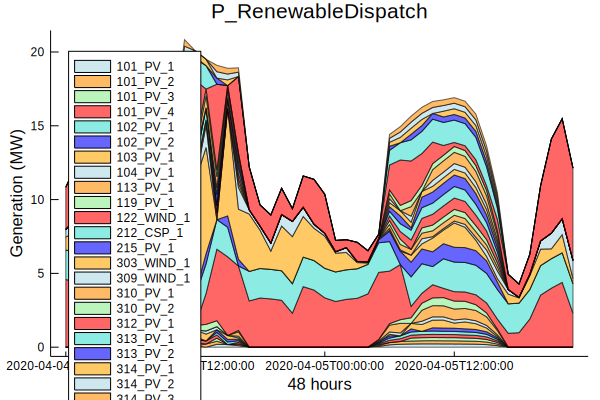

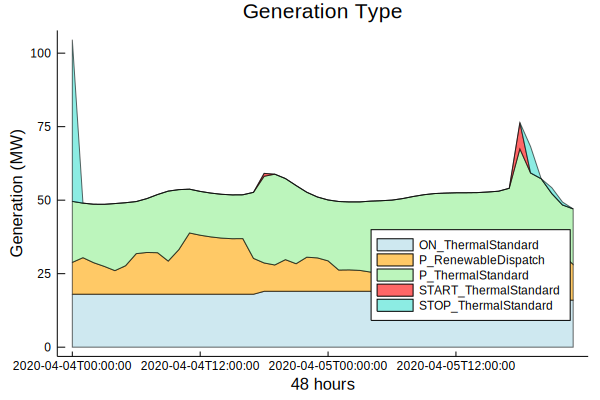

In [71]:
PSI.stack_plot(res)

# Sequential simulations

## Recipe for UC stage

In [62]:
## UC Model Ref
branches = Dict{Symbol, DeviceModel}(#:L => DeviceModel(PSY.Line, PSI.StaticLine),
                                     #:T => DeviceModel(PSY.Transformer2W, PSI.StaticTransformer),
                                     #:TT => DeviceModel(PSY.TapTransformer, PSI.StaticTransformer),
                                     #:dc_line => DeviceModel(PSY.HVDCLine, PSI.HVDCDispatch)
                                    )

services = Dict{Symbol, PSI.ServiceModel}()

devices = Dict{Symbol, DeviceModel}(:Generators => DeviceModel(PSY.ThermalStandard, PSI.ThermalBasicUnitCommitment),
                                    :Ren => DeviceModel(PSY.RenewableDispatch, PSI.RenewableFullDispatch),
                                    :Loads =>  DeviceModel(PSY.PowerLoad, PSI.StaticPowerLoad),
                                    #:ILoads =>  DeviceModel(PSY.InterruptibleLoad, PSI.StaticPowerLoad),
                                    )       


model_ref_uc= ModelReference(CopperPlatePowerModel, devices, branches, services);

## Recipe for ED stage
 - Includes reference to information obtained from UC results

In [63]:
## ED Model Ref
branches = Dict{Symbol, DeviceModel}(#:L => DeviceModel(PSY.Line, PSI.StaticLine),
                                     #:T => DeviceModel(PSY.Transformer2W, PSI.StaticTransformer),
                                     #:TT => DeviceModel(PSY.TapTransformer, PSI.StaticTransformer),
                                     #:dc_line => DeviceModel(PSY.HVDCLine, PSI.HVDCDispatch)
                                        )

services = Dict{Symbol, PSI.ServiceModel}()

devices = Dict{Symbol, DeviceModel}(:Generators => DeviceModel(PSY.ThermalStandard, PSI.ThermalDispatch, SemiContinuousFF(:P, :ON)),
                                    :Ren => DeviceModel(PSY.RenewableDispatch, PSI.RenewableFullDispatch),
                                    :Loads =>  DeviceModel(PSY.PowerLoad, PSI.StaticPowerLoad),
                                    #:ILoads =>  DeviceModel(PSY.InterruptibleLoad, PSI.DispatchablePowerLoad),
                                    )       

model_ref_ed= ModelReference(CopperPlatePowerModel, devices, branches, services);

## Simulation recipe
 - `Dict{Int, Stage}` maps the order of stages
 - `Stage` defines:
  - the problem recipe
  - the number of times each problem is solved before moving on to the next stage
  - `System`
  - solver
  - and a description of where to get initial condition information

In [64]:
stages = Dict(1 => Stage(model_ref_uc, 1, sys_DA, Cbc_optimizer),
              2 => Stage(model_ref_ed, 24, sys_RT, Cbc_optimizer,  Dict(1 => Synchronize)))

Dict{Int64,Stage} with 2 entries:
  2 => Simulation Stage…
  1 => Simulation Stage…

## Build `Simulation`

In [65]:
sim = Simulation("test", 2, stages, "/Users/cbarrows/Downloads/"; verbose = true, system_to_file = false)

┌ Info: Building Stage 2
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/core/build_simulations.jl:81
┌ Info: Building ThermalStandard with ThermalDispatch formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/core/build_operations.jl:14
┌ Info: Building RenewableDispatch with RenewableFullDispatch formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/core/build_operations.jl:14
┌ Info: Building PowerLoad with StaticPowerLoad formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/core/build_operations.jl:14
┌ Info: Building CopperPlatePowerModel network formulation
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/core/build_operations.jl:19
┌ Info: Building Objective
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/core/build_operations.jl:34
┌ Info: Building Stage 1
└ @ PowerSimula

Simulation Model


## run `Simulation`

In [30]:
res = run_sim_model!(sim)

┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{Cbc.Optimizer,MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.Model{Float64}}}}. This 
│   information will be discarded. = information will be discarded.
└ @ MathOptInterface.Utilities /Users/cbarrows/.julia/packages/MathOptInterface/4hMCx/src/Utilities/copy.jl:140
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72


Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Dec 31 2018 

command line - Cbc_C_Interface -ratioGap 0.1 -logLevel 1 -solve -quit (default strategy 1)
ratioGap was changed from 0 to 0.1
Continuous objective value is 1.9061e+06 - 0.35 seconds
Cgl0004I processed model has 17671 rows, 28162 columns (10786 integer (10786 of which binary)) and 56355 elements
Cbc0038I Initial state - 567 integers unsatisfied sum - 147.794
Cbc0038I Pass   1: (0.69 seconds) suminf.    4.46719 (31) obj. 2.02434e+06 iterations 3363
Cbc0038I Pass   2: (0.71 seconds) suminf.    0.57622 (16) obj. 2.02785e+06 iterations 85
Cbc0038I Pass   3: (0.73 seconds) suminf.    0.00000 (0) obj. 2.16348e+06 iterations 114
Cbc0038I Solution found of 2.16348e+06
Cbc0038I Relaxing continuous gives 2.13854e+06
Cbc0038I Before mini branch and bound, 10188 integers at bound fixed and 15480 continuous
Cbc0038I Full problem 17671 rows 28162 columns, reduced to 132 rows 435 columns
Cbc0038I Mini branch and bound improved s

┌ Warning: MathOptInterface.VariablePrimalStart() is not supported by MathOptInterface.Bridges.LazyBridgeOptimizer{MathOptInterface.Utilities.CachingOptimizer{Cbc.Optimizer,MathOptInterface.Utilities.UniversalFallback{MathOptInterface.Utilities.Model{Float64}}}}. This 
│   information will be discarded. = information will be discarded.
└ @ MathOptInterface.Utilities /Users/cbarrows/.julia/packages/MathOptInterface/4hMCx/src/Utilities/copy.jl:140
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by 

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Dec 31 2018 

command line - Cbc_C_Interface -ratioGap 0.1 -logLevel 1 -solve -quit (default strategy 1)
ratioGap was changed from 0 to 0.1
Presolve 228 (-2832) rows, 1044 (-3732) columns and 1260 (-6564) elements
Perturbing problem by 0.001 %% of 281.27276 - largest nonzero change 3.1007845e-05 (%% 1.5401445e-05) - largest zero change 3.0942664e-05
0  Obj 3095.5412 Primal inf 225.42838 (228)
79  Obj 12478.971 Primal inf 205.01654 (195)
158  Obj 31617.355 Primal inf 117.64024 (130)
237  Obj 38415.268 Primal inf 40.035163 (64)
307  Obj 43810.689
Optimal - objective value 43810.679
After Postsolve, objective 43810.679, infeasibilities - dual 9824.1343 (48), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
Optimal - objective value 43810.679
Optimal objective 43810.67947 - 307 iterations time 0.012, Presolve 0.00
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01

Welcome to the CBC MILP 

┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:7

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Dec 31 2018 

command line - Cbc_C_Interface -ratioGap 0.1 -logLevel 1 -solve -quit (default strategy 1)
ratioGap was changed from 0 to 0.1
Presolve 240 (-2820) rows, 1104 (-3672) columns and 1332 (-6492) elements
Perturbing problem by 0.001 %% of 368.8 - largest nonzero change 3.9761851e-05 (%% 1.6283399e-05) - largest zero change 3.9729034e-05
0  Obj 3095.5429 Primal inf 225.42837 (240)
79  Obj 10325.735 Primal inf 232.19663 (214)
158  Obj 27190.058 Primal inf 133.79391 (150)
237  Obj 34993.873 Primal inf 77.861783 (97)
316  Obj 43481.985 Primal inf 30.570858 (35)
352  Obj 43712.78
Optimal - objective value 43712.768
After Postsolve, objective 43712.768, infeasibilities - dual 9524.2296 (48), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
Optimal - objective value 43712.768
Optimal objective 43712.76843 - 352 iterations time 0.012, Presolve 0.00
Total time (CPU seconds):       0.01   (Wallclock second

┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:7

Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Dec 31 2018 

command line - Cbc_C_Interface -ratioGap 0.1 -logLevel 1 -solve -quit (default strategy 1)
ratioGap was changed from 0 to 0.1
Presolve 228 (-2832) rows, 1044 (-3732) columns and 1260 (-6564) elements
Perturbing problem by 0.001 %% of 281.27276 - largest nonzero change 3.1007845e-05 (%% 1.5401445e-05) - largest zero change 3.0942664e-05
0  Obj 3095.5412 Primal inf 225.42838 (228)
79  Obj 12478.971 Primal inf 205.01654 (195)
158  Obj 31617.355 Primal inf 117.64024 (130)
237  Obj 38415.268 Primal inf 40.035163 (64)
307  Obj 43810.689
Optimal - objective value 43810.679
After Postsolve, objective 43810.679, infeasibilities - dual 9824.1343 (48), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
Optimal - objective value 43810.679
Optimal objective 43810.67947 - 307 iterations time 0.012, Presolve 0.00
Total time (CPU seconds):       0.01   (Wallclock seconds):       0.01

Welcome to the CBC MILP 

┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72


Welcome to the CBC MILP Solver 
Version: 2.9.9 
Build Date: Dec 31 2018 

command line - Cbc_C_Interface -ratioGap 0.1 -logLevel 1 -solve -quit (default strategy 1)
ratioGap was changed from 0 to 0.1
Presolve 240 (-2820) rows, 1104 (-3672) columns and 1332 (-6492) elements
Perturbing problem by 0.001 %% of 368.8 - largest nonzero change 3.9761851e-05 (%% 1.6283399e-05) - largest zero change 3.9729034e-05
0  Obj 3095.5429 Primal inf 225.42837 (240)
79  Obj 10325.735 Primal inf 232.19663 (214)
158  Obj 27190.058 Primal inf 133.79391 (150)
237  Obj 34993.873 Primal inf 77.861783 (97)
316  Obj 43481.985 Primal inf 30.570858 (35)
352  Obj 43712.78
Optimal - objective value 43712.768
After Postsolve, objective 43712.768, infeasibilities - dual 9524.2296 (48), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
Optimal - objective value 43712.768
Optimal objective 43712.76843 - 352 iterations time 0.012, Presolve 0.00
Total time (CPU seconds):       0.01   (Wallclock second

┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
┌ Warning: SolveTime() property not supported by the Solver
└ @ PowerSimulations /Users/cbarrows/.julia/packages/PowerSimulations/AZa6K/src/routines/write_model.jl:72
